Note: x-axis is taken to be span-wise, and y-axis is taken to be chord-wise

V(infinity) is taken to be 1m/s

Span is taken tp be 1m

Creating control panels similar to as shown in this image:

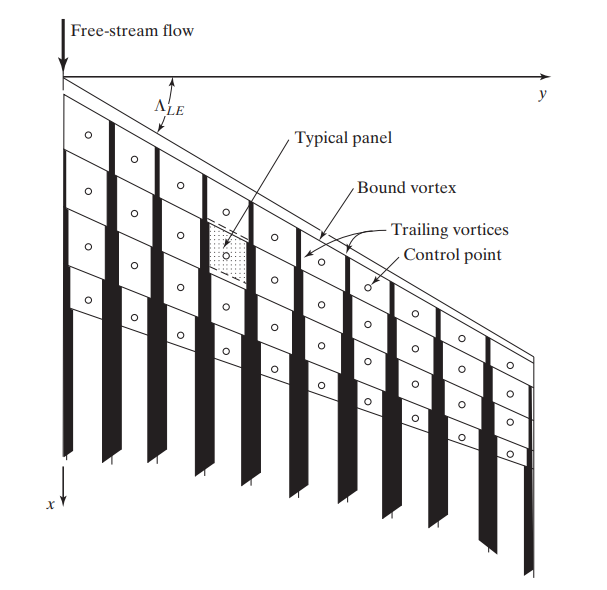

Formulae used:

For finding coefficient at mth control point due the nth panel:

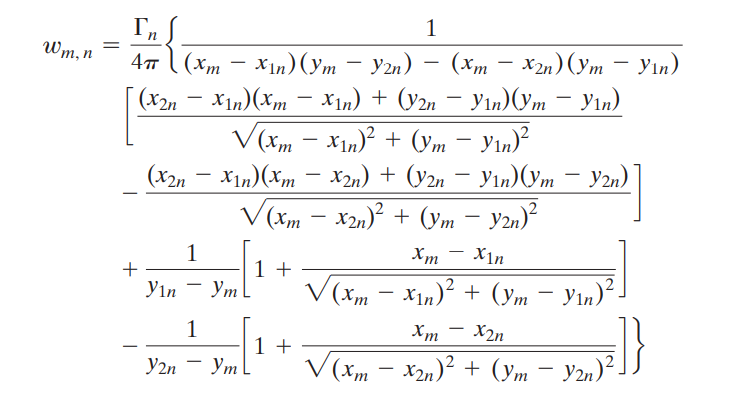

For no throughflow condition:

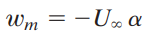

For calculating lift using calculated circulationsn afer converting integration into summation:

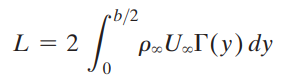

For calculating lift coefficient of wing using lift:

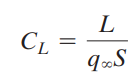

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def vlm_solver(SwpCQrtr, TprRatio, AspctRatio, MLtcB, NLtcC, alpha):
  # Assumption: the vertex of the wing, center of the LE of wing, is origin (0, 0)
  vinfi = 1
  span = 1  # span
  # first finding the x coordinates of the control points, i.e. along x-axis or
  # span, so if we need M panels along half span, therefore, each panel will be
  # span/M wide
  mac = span/AspctRatio # calculating mean aerodynamic chord
  cRoot = 2*mac/(1 + TprRatio) # Root chord
  cTip = cRoot*TprRatio # Tip chord
  hspan = span/2  # half span to do calculations for one side of the winf, say starboard side
  panwid = hspan/MLtcB # width of panel (means length in x-direction)
    # LE sweep angle using quarter chord sweep, needed for finding y coordinate
    # of LE at different span locations
  print("Chord length at root:", cRoot,"\nChord at tip:", cTip)
  if TprRatio == 0:   # for case of delta wing
    SwpLE = np.arctan(cRoot/hspan)
    print("Sweep angle at leading edge: ", -SwpLE*180/np.pi, "\n")
  elif SwpCQrtr <= 0 and TprRatio != 0:  # for backward swept wing
    SwpLE = np.arctan((hspan*np.tan(abs(SwpCQrtr*np.pi/180)) + (cRoot-cTip)/4)/hspan)
    print("Sweep angle at leading edge: ", -SwpLE*180/np.pi, "\n")
  elif SwpCQrtr > 0 and TprRatio != 0: # for forward swept wing
    SwpLE = -np.arctan((hspan*np.tan(abs(SwpCQrtr*np.pi/180)) - (cRoot-cTip)/4)/hspan)
    print("Sweep angle at leading edge: ", -SwpLE*180/np.pi, "\n")

  def calculateX(i): # this will calculate x-coordinates for both bounds as well as control points
                     # depending on the ith panel (i varying from 0 to MLtcB)
    panCpx = panwid/2 + panwid*i # Control panel x starting from middle of first panel
    panBndx = panwid*i    # remember to add final coordinate hspan of final bound vortex
    return panCpx, panBndx

  """okay, now let's use all these functions to get a list of x locations for
  bound vortices and also the control points"""
  def storeX():
    indices = np.arange(MLtcB) # making an array which will help in calling calculateX(indices) for
                               # all spanwise locations
    panCpx, panBndx  = calculateX(indices) # calling calculateX(indices) with indices and storing arrys of x's
    BndMLtcB = np.array(hspan)
    panBndx = np.append(panBndx, BndMLtcB) # adding last value of bound x coordinate
    return panCpx, panBndx

  """defining the function which will calculate the chord length at particular x
  location along the span in consideration and the starting point of this chord,
  means the y coordinate of LE at this location along span"""
  def calculateCh(loc): # taking input as x location where chord is being calculated
    chLoc = cRoot - (cRoot - cTip)*abs(loc)/hspan # calculating chord at given x
    return chLoc

  """writing function for updating y depending on at what span location we need the
  y coordinates, this fucntion will return the list of all the y's at that x (span location)"""
  def calculateY(index, case):    # taking input as loc and cLoc, means the location x and
    # the chord at x coordinate along the span
    if case.upper() == 'CP':
      X = calculateX(index)[0]
      chLoc = calculateCh(X)
      panlen = chLoc/NLtcC # length of panel in y (chordwise) direction
      cpYi = 3*panlen/4 # for case of Cp, y will start from 3/4 of panel length
    elif case.upper() == 'BND':
      X = calculateX(index)[1]
      chLoc = calculateCh(X)
      panlen = chLoc/NLtcC
      cpYi = panlen/4 # for case of Cp, y will start from 1/4 of panel length
    yList = np.zeros((NLtcC, len(index)))
    yList[0, :] = cpYi + np.tan(SwpLE)*X
    for i in range(1, NLtcC):
      yList[i, :] = yList[i-1, :] + panlen # adding panel length to previous value of y
    return yList

  """ well, now let's use all these functions to get a list of y coordinates for
  bound vortices and also the control points"""
  def storeY():
    indices = np.arange(MLtcB)
    panCpy = calculateY(indices, 'Cp') # calling calculateY(indices) with an array indices for both Cp and Bnd case
    panBndy = calculateY(indices, 'Bnd')
    BndMLtcBy = np.zeros(NLtcC)
    BndMLtcBy[0] = np.tan(SwpLE)*hspan + cTip/(4*NLtcC)
    for i in range(1, NLtcC): # creating the list of last y's, means the y's at tip of wing for bound
      BndMLtcBy[i] = BndMLtcBy[i-1] + cTip/NLtcC
    panBndy = np.column_stack((panBndy, BndMLtcBy)) # appending tip y's as a column to other y's
    return panCpy, panBndy

  """ now defining a function which calculates and stores downswash velocity at all
  control points due to its own and all other lattices"""
  def calculateDwnwsh():
    # first it will call storeX and storeY for its local reference and store values
    # in a local variable
    CpX, BndX = storeX() # storing x coordinates of control  points and bounds, locally
    CpY, BndY = storeY() # storing y coordinates of control  points and bounds, locally
    """print("Matrix containing x-coordinates (spanwise) of control points:\n" + str(CpX), "\n")
    print("Matrix containing x-coordinates (spanwise) of bound vortices:\n" + str(BndX), "\n")
    print("Matrix containing y-coordinates (chord-wise) of control points:\n" + str(CpY), "\n")
    print("Matrix containing y-coordinates (chord-wsie) of bound vortices:\n" + str(BndY), "\n")""" # remove inverted commas, if needed

    # we will write the equation for storing all the coeffcients corresponding to
    # all the gammas (circulations of lattices). we will make a two-d array with
    # each of MLtcB columns containing circulations of lattices at particular span
    # location and having NLtcC rows
    # now writing loop which will run over all the lattices calculating contributions
    # of all the lattices at all the control points
    gammaCoeff = np.zeros((MLtcB*NLtcC, MLtcB*NLtcC)) # each row of this array will have coefficients of each equation
                 # calculated for each control points
    coeffRow = 0 # setting the initial row to 0
    for l in range(MLtcB): # here, l and k will fix the control point where equation is being generated
      for k in range(NLtcC):
        wEqn = np.zeros(MLtcB*NLtcC)
        m = 0 # equation at each Cp will be having M*N terms, therefore, using m we will store each term's coefficient
        for j in range(MLtcB): # here, j and i will fix the panel whose contribution at given (l, k) panel is being calculated
          for i in range(NLtcC): # storing each coefficient of the equation
            wEqn[m] = ((((CpY[k][l]-BndY[i][j])*(CpX[l]-BndX[j+1])-(CpY[k][l]-BndY[i][j+1])*(CpX[l]-BndX[j]))**(-1)*\
            ((((BndY[i][j+1]-BndY[i][j])*(CpY[k][l]-BndY[i][j])+(BndX[j+1]-BndX[j])*(CpX[l]-BndX[j]))/\
              (np.sqrt((CpY[k][l]-BndY[i][j])**2+(CpX[l]-BndX[j])**2)))-\
              (((BndY[i][j+1]-BndY[i][j])*(CpY[k][l]-BndY[i][j+1])+(BndX[j+1]-BndX[j])*(CpX[l]-BndX[j+1]))/\
              (np.sqrt((CpY[k][l]-BndY[i][j+1])**2+(CpX[l]-BndX[j+1])**2)))))-\
            ((CpX[l]-BndX[j])**(-1)*(1.0+(CpY[k][l]-BndY[i][j])/np.sqrt((CpY[k][l]-BndY[i][j])**2+(CpX[l]-BndX[j])**2)))+\
            ((CpX[l]-BndX[j+1])**(-1)*(1.0+(CpY[k][l]-BndY[i][j+1])/np.sqrt((CpY[k][l]-BndY[i][j+1])**2+(CpX[l]-BndX[j+1])**2))))\
            +\
            (((-1*(CpY[k][l]-BndY[i][j])*(CpX[l]+BndX[j+1])+(CpY[k][l]-BndY[i][j+1])*(CpX[l]+BndX[j]))**(-1)*\
            ((((BndY[i][j+1]-BndY[i][j])*(CpY[k][l]-BndY[i][j])+(-1*BndX[j+1]+BndX[j])*(CpX[l]+BndX[j]))/\
              (np.sqrt((CpY[k][l]-BndY[i][j])**2+(CpX[l]+BndX[j])**2)))-\
              (((BndY[i][j+1]-BndY[i][j])*(CpY[k][l]-BndY[i][j+1])+(-1*BndX[j+1]+BndX[j])*(CpX[l]+BndX[j+1]))/\
              (np.sqrt((CpY[k][l]-BndY[i][j+1])**2+(CpX[l]+BndX[j+1])**2)))))+\
            ((CpX[l]+BndX[j])**(-1)*(1.0+(CpY[k][l]-BndY[i][j])/np.sqrt((CpY[k][l]-BndY[i][j])**2+(CpX[l]+BndX[j])**2)))-\
            ((CpX[l]+BndX[j+1])**(-1)*(1.0+(CpY[k][l]-BndY[i][j+1])/np.sqrt((CpY[k][l]-BndY[i][j+1])**2+(CpX[l]+BndX[j+1])**2))))
            m = m + 1
        gammaCoeff[coeffRow] = wEqn # storing all coefficients of each equation as a separate row in bigger coefficients matrix
        coeffRow = coeffRow + 1 # updating the row where coefficients to be stored next time
        wEqn = np.zeros(MLtcB*NLtcC) # resetting the equation after storing
        m = 0 # resetting the coefficient number for storing coefficients from start for next control point
    coeffRow = 0 # resetting the row after storing
    #print(gammaCoeff) # remove '#' at start for printing, if needed
    return gammaCoeff

  """ now we have the function for creating a matrix of coefficients of gamma's at
  all control points; now we will make a matrix B to solve for gammas using
  Ax = B ==> x = inv(A)*B"""
  def dCl_alpha():
    gamCoef = calculateDwnwsh() # storing coefficients of the equations, locally, let's name A
    #print(gamCoef)
    # downwash at each point is cancelled by the normal component (V(infinity)*sin(alpha)) of the freestream velocoity for a planar wing
    freestream = -1*vinfi*alpha*np.pi/180 # for solution matrix 'x' containing circulations of the vortices using x = inverse(A) X B
    freestrm = np.full(MLtcB*NLtcC, freestream) # creating the B matrix with all elements as normal component of freestream
    gamma = np.linalg.inv(gamCoef) @ freestrm # solving linear equattions for circulations of vortices using matrix multiplication
    #print("Values of strenghts of circulations calculated:\n" + str(gamma), "\n")
    dCl_alfa = 16*np.pi*sum(gamma)*panwid/(vinfi**2*span*mac)/(alpha*np.pi/180) # calculating dCl by dAlpha
    #Cl = dCl_alfa*alpha*np.pi/180
    #print("Cl at", alpha, "degrees of angle of attack is:", Cl,"\n")
    print("dCl/dα for this configuration is:", dCl_alfa, "per radian or", dCl_alfa*np.pi/180, "per degree\n")
    return dCl_alfa
  return dCl_alpha()

Running all the asked problems for two cases, namely, case1 and case2.
Here, case1 is normally run for M = 4 and N = 1, and case2 is run for some other random M and N. The value of dCl/dα is assumed to be converging if the difference is less than 5% in both the cases. The differenec actually gets very small if the M and N are increased for both the cases.

For users' help:

vlm_solver(Sweep_for_quarter_chord, Taper_ratio, Aspect_ratio, No._of lattices_on_halfspan, No._of lattices_in_chord_direction, Angle_of_attack_of_flight)

fucntion expects values in above order

Example 7.4

In [ ]:
print("Case 1:\n")
case1 = vlm_solver(-45, 1, 5, 4, 1, 5)
print("\n" + str("=="*80), "\n")
print("Case 2:\n")
case2 = vlm_solver(-45, 1, 5, 10, 8, 5)
change = abs(float(case2) - float(case1))/float(case1)*100
if change<=5:
  print("\nThe difference b/w dCl/dα, calculated for different MxN, only has difference of", change, "%.\n"\
        "Therefore, we can say that results are converging.")
print("\n" + str("**"*80), "\n")

Case 1:

Chord length at root: 0.2 
Chord at tip: 0.2
Sweep angle at leading edge:  -45.0 

dCl/dα for this configuration is: 3.4442241877137145 per radian or 0.06011305225243155 per degree



Case 2:

Chord length at root: 0.2 
Chord at tip: 0.2
Sweep angle at leading edge:  -45.0 

dCl/dα for this configuration is: 3.29073157772403 per radian or 0.05743410083063201 per degree


The difference b/w dCl/dα, calculated for different MxN, only has difference of 4.456522038757684 %.
Therefore, we can say that results are converging.

**************************************************************************************************************************************************************** 



Problem 7.9

In [ ]:
print("Case 1:\n")
case1 = vlm_solver(-45, 1, 8, 4, 1, 5)
print("\n" + str("=="*80), "\n")
print("Case 2:\n")
case2 = vlm_solver(-45, 1, 8, 10, 8, 5)
change = abs(float(case2) - float(case1))/float(case1)*100
if change<=5:
  print("\nThe difference b/w dCl/dα, calculated for different MxN, only has difference of", change, "%.\n"\
        "Therefore, we can say that results are converging.")
print("\nAlso, in comparison to the above solved Example 7.4 Problem 7.9 gives increased dCl/dα.\n"\
      "This is consistent with Fig. 7.10 in the book which shows that dCl/dα increases with\n"\
      "increase in Aspect Ratio")
print("\n" + str("**"*80), "\n")

Case 1:

Chord length at root: 0.125 
Chord at tip: 0.125
Sweep angle at leading edge:  -45.0 

dCl/dα for this configuration is: 3.7873277802285075 per radian or 0.06610133961723566 per degree



Case 2:

Chord length at root: 0.125 
Chord at tip: 0.125
Sweep angle at leading edge:  -45.0 

dCl/dα for this configuration is: 3.638119305931893 per radian or 0.06349716046888239 per degree


The difference b/w dCl/dα, calculated for different MxN, only has difference of 3.9396768105350572 %.
Therefore, we can say that results are converging.

Also, in comparison to the above solved Example 7.4 Problem 7.9 gives increased dCl/dα.
This is consistent with Fig. 7.10 in the book which shows that dCl/dα increases with
increase in Aspect Ratio

**************************************************************************************************************************************************************** 



Problem 7.10

In [ ]:
print("Case 1:\n")
case1 = vlm_solver(-45, 0.5, 5, 4, 1, 5)
print("\n" + str("=="*80), "\n")
print("Case 2:\n")
case2 = vlm_solver(-45, 0.5, 5, 10, 8, 5)
change = abs(float(case2) - float(case1))/float(case1)*100
if change<=5:
  print("\nThe difference b/w dCl/dα, calculated for different MxN, only has difference of", change, "%.\n"\
        "Therefore, we can say that results are converging.")
print("\n" + str("**"*80), "\n")

Case 1:

Chord length at root: 0.26666666666666666 
Chord at tip: 0.13333333333333333
Sweep angle at leading edge:  -46.8476102659946 

dCl/dα for this configuration is: 3.5768386836074177 per radian or 0.06242761184164917 per degree



Case 2:

Chord length at root: 0.26666666666666666 
Chord at tip: 0.13333333333333333
Sweep angle at leading edge:  -46.8476102659946 

dCl/dα for this configuration is: 3.4574458178106355 per radian or 0.06034381323010359 per degree


The difference b/w dCl/dα, calculated for different MxN, only has difference of 3.3379438201660423 %.
Therefore, we can say that results are converging.

**************************************************************************************************************************************************************** 



Problem 7.11

Case 1:

Chord length at root: 0.37558685446009393 
Chord at tip: 0.18779342723004697
Sweep angle at leading edge:  42.17982752755151 

dCl/dα for this configuration is: 3.0604250823972508 per radian or 0.053414494198450777 per degree



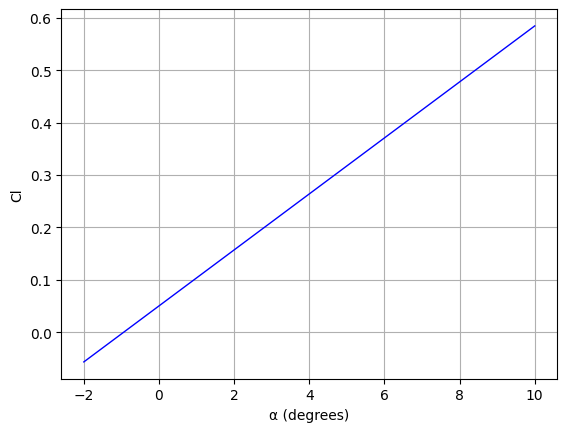



Case 2:

Chord length at root: 0.37558685446009393 
Chord at tip: 0.18779342723004697
Sweep angle at leading edge:  42.17982752755151 

dCl/dα for this configuration is: 2.9635078650025966 per radian or 0.05172296965304295 per degree


The difference b/w dCl/dα, calculated for different MxN, only has difference of 3.166789409487466 %.
Therefore, we can say that results are converging.

-What will happen in this case is that, due to the negative alpha for zero lift, the dCl/dα graph
will shift towards the left by α@L=0 amount and will loop like as shown above-

**************************************************************************************************************************************************************** 



In [ ]:
print("Case 1:\n")
case1 = vlm_solver(45, 0.5, 3.55, 4, 1, 5)
# As dCl/dα graph will be a straight line so, let's get two points of this line for plotting
cla = float(case1)*np.pi/180
x = [-2, 10]
y = [cla*(-2+0.94), cla*(10+0.94)]
plt.plot(x, y, color = 'blue', linewidth = 1.0); plt.ylabel("Cl"); plt.xlabel("α (degrees)")
plt.grid(True)
plt.show()
print("\n" + str("=="*80), "\n")
print("Case 2:\n")
case2 = vlm_solver(45, 0.5, 3.55, 10, 8, 5)
change = abs(float(case2) - float(case1))/float(case1)*100
if change<=5:
  print("\nThe difference b/w dCl/dα, calculated for different MxN, only has difference of", change, "%.\n"\
        "Therefore, we can say that results are converging.")
print("\n-What will happen in this case is that, due to the negative alpha for zero lift, the dCl/dα graph\n"\
      "will shift towards the left by α@L=0 amount and will loop like as shown above-")
print("\n" + str("**"*80), "\n")

Problem 7.12

Case 1:

Chord length at root: 1.3333333333333333 
Chord at tip: 0.0
Sweep angle at leading edge:  -69.44395478041653 

dCl/dα for this configuration is: 1.7907257007033244 per radian or 0.031254059477355545 per degree



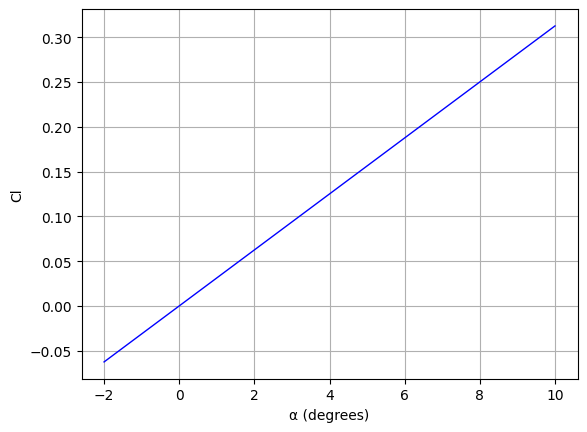



Case 2:

Chord length at root: 1.3333333333333333 
Chord at tip: 0.0
Sweep angle at leading edge:  -69.44395478041653 

dCl/dα for this configuration is: 1.7926164506710764 per radian or 0.031287059289624795 per degree


The difference b/w dCl/dα, calculated for different MxN, only has difference of 0.1055856833355025 %.
Therefore, we can say that results are converging.

**************************************************************************************************************************************************************** 



In [ ]:
print("Case 1:\n")
case1 = vlm_solver(0, 0, 1.5, 4, 1, 5) # sweep at quarter chord is ignored for delta wing case, above in chord directly
        # swepp at LE is calculated using aspect ratio and chord at root. Also, taper ratio is said to be zero for delta wing
cla = float(case1)*np.pi/180
x = [-2, 10]
y = [cla*(-2), cla*10]
plt.plot(x, y, color = 'blue', linewidth = 1.0); plt.ylabel("Cl"); plt.xlabel("α (degrees)")
plt.grid(True)
plt.show()
print("\n" + str("=="*80), "\n")
print("Case 2:\n")
case2 = vlm_solver(0, 0, 1.5, 9, 5, 5)
change = abs(float(case2) - float(case1))/float(case1)*100
if change<=5:
  print("\nThe difference b/w dCl/dα, calculated for different MxN, only has difference of", change, "%.\n"\
        "Therefore, we can say that results are converging.")
print("\n" + str("**"*80), "\n")

==> Comparing swept-back and forward swept wing for similar other parameters, here done for Problem 7.10

Case 1 (backward swept):

Chord length at root: 0.16666666666666666 
Chord at tip: 0.08333333333333333
Sweep angle at leading edge:  -46.169139327907416 

dCl/dα for this configuration is: 3.7797051999432476 per radian or 0.06596830049376026 per degree



Case 2 (forward swept):

Chord length at root: 0.16666666666666666 
Chord at tip: 0.08333333333333333
Sweep angle at leading edge:  43.7811247648687 

dCl/dα for this configuration is: 3.6391909350807476 per radian or 0.06351586392589026 per degree

Here, we can notice the change of 3.717598527647336 % b/w backward and forward swept wing with all other parameters held the same



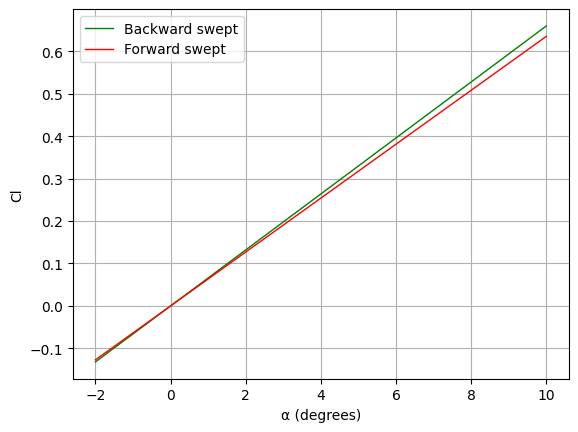


**************************************************************************************************************************************************************** 



In [ ]:
print("Case 1 (backward swept):\n")
case1 = vlm_solver(-45, 0.5, 8, 11, 8, 5)
print("\n" + str("=="*80), "\n")
print("Case 2 (forward swept):\n")
case2 = vlm_solver(45, 0.5, 8, 11, 8, 5)
change = abs(float(case2) - float(case1))/float(case1)*100
print("Here, we can notice the change of", change, "% b/w backward and forward swept wing with all other parameters held the same\n")
cla1 = float(case1)*np.pi/180
cla2 = float(case2)*np.pi/180
x = [-2, 10]
y1 = [cla1*(-2), cla1*10]
y2 = [cla2*(-2), cla2*10]
plt.plot(x, y1, color = 'green', linewidth = 1.0)
plt.plot(x, y2, color = 'red', linewidth = 1.0)
plt.ylabel("Cl"); plt.xlabel("α (degrees)"); plt.legend(["Backward swept", "Forward swept"], loc = "best")
plt.grid(True)
plt.show()
print("\n" + str("**"*80), "\n")